<a href="https://colab.research.google.com/github/Mattmack1/Machine-Learning-Projects/blob/main/KNNWinePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Use nearest neighbor models to try and predict whether or not the quality of wine is good (1) or bad (0).

### Read in all of our inputs

In [1]:
import math

import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read in the training and testing data.

In [3]:
train_data = pd.read_csv("train.csv").drop(columns=['id'])
test_data = pd.read_csv("test.csv").drop(columns=['id'])

# Get an idea of what is in the training and testing data.

In [ ]:
train_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.5,0.40,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0,0
1,11.5,0.18,0.51,4.0,0.104,4.0,23.0,0.99960,3.28,0.97,10.1,1
2,8.2,0.34,0.37,1.9,0.057,43.0,74.0,0.99408,3.23,0.81,12.0,1
3,10.7,0.43,0.39,2.2,0.106,8.0,32.0,0.99860,2.89,0.50,9.6,0
4,7.6,0.42,0.25,3.9,0.104,28.0,90.0,0.99784,3.15,0.57,9.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
794,6.6,0.96,0.00,1.8,0.082,5.0,16.0,0.99360,3.50,0.44,11.9,1
795,7.5,0.58,0.56,3.1,0.153,5.0,14.0,0.99476,3.21,1.03,11.6,1
796,5.6,0.31,0.78,13.9,0.074,23.0,92.0,0.99677,3.39,0.48,10.5,1
797,8.4,0.62,0.12,1.8,0.072,38.0,46.0,0.99504,3.38,0.89,11.8,1


In [ ]:
test_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.3,0.67,0.05,3.6,0.107,6.0,20.0,0.99720,3.40,0.63,10.1
1,7.6,0.49,0.26,1.6,0.236,10.0,88.0,0.99680,3.11,0.80,9.3
2,8.1,0.56,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3
3,8.3,0.31,0.39,2.4,0.078,17.0,43.0,0.99444,3.31,0.77,12.5
4,7.3,0.51,0.18,2.1,0.070,12.0,28.0,0.99768,3.52,0.73,9.5
...,...,...,...,...,...,...,...,...,...,...,...
795,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9
796,8.2,0.35,0.33,2.4,0.076,11.0,47.0,0.99599,3.27,0.81,11.0
797,13.5,0.53,0.79,4.8,0.120,23.0,77.0,1.00180,3.18,0.77,13.0
798,6.5,0.88,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2


## Check to see how the data is distributed. There are some values that range between decimals (chlorides) and others that range between the hundreds (sulfur dioxide).

## It may be important to scale, normalize, or standardize the data.

## We can also see that there are no null values in our data.

In [ ]:
train_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,8.404255,0.532972,0.275207,2.543930,0.087874,15.732791,46.568836,0.996901,3.310300,0.663692,10.371652,0.534418
std,1.820637,0.180163,0.199743,1.380552,0.046212,10.102371,32.453258,0.001891,0.158626,0.178889,1.038703,0.499126
min,4.600000,0.160000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990640,2.740000,0.370000,8.400000,0.000000
25%,7.100000,0.395000,0.090000,1.900000,0.071000,7.000000,22.000000,0.995725,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,37.000000,0.996820,3.310000,0.620000,10.100000,1.000000
75%,9.300000,0.640000,0.440000,2.600000,0.091000,21.000000,65.000000,0.998000,3.400000,0.735000,11.000000,1.000000
max,15.600000,1.580000,1.000000,15.500000,0.610000,55.000000,278.000000,1.003690,4.010000,2.000000,14.000000,1.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         799 non-null    float64
 1   volatile acidity      799 non-null    float64
 2   citric acid           799 non-null    float64
 3   residual sugar        799 non-null    float64
 4   chlorides             799 non-null    float64
 5   free sulfur dioxide   799 non-null    float64
 6   total sulfur dioxide  799 non-null    float64
 7   density               799 non-null    float64
 8   pH                    799 non-null    float64
 9   sulphates             799 non-null    float64
 10  alcohol               799 non-null    float64
 11  quality               799 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 75.0 KB


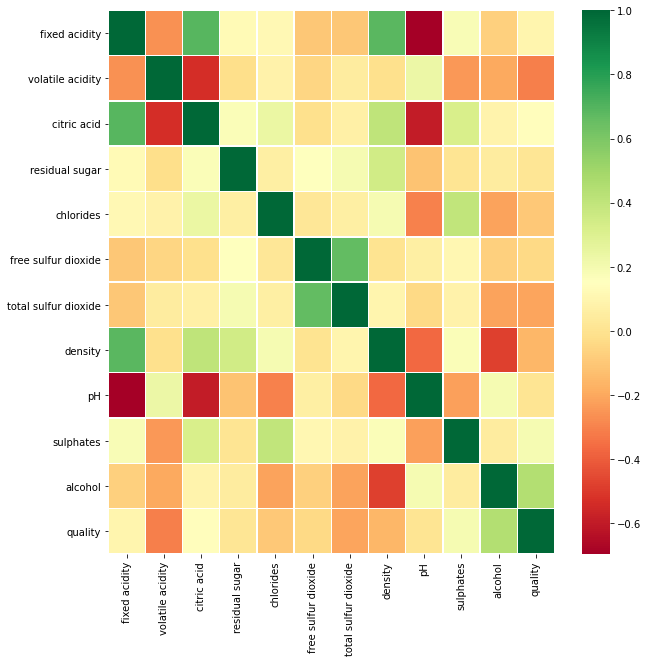

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(train_data.corr(), cmap='RdYlGn', linewidths=.5)

## Checking to see how correlated the data is to quality. At a glance you can see alcohol and volatile acidity seem to have an effect on quality while fixed acidity, sulphates, and citric acid have less of an effect.

In [ ]:
train_data.isna().sum().sum()

0

We can be extra confident there are no missing values.

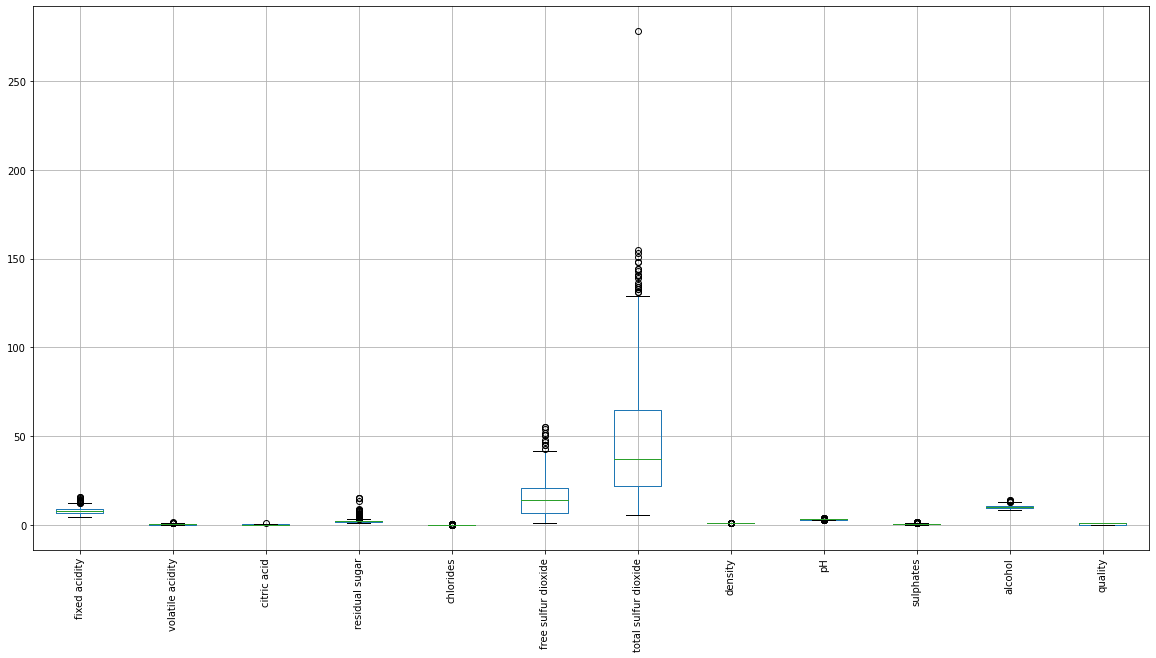

In [ ]:
train_data.loc[:, train_data.columns.to_list()].boxplot(figsize=(20,10), rot=90);

## There are some outliers in the data and it could probably due with some level of normalization/standardization

# Split our data so that the quality column is our Y and the rest of our data is our X.

In [4]:
y_train = train_data.iloc[:,-1:]
X_train = train_data.iloc[:,:-1]



Train test split the data.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .15, stratify = y_train)

I non-systematically tried many test sizes. Later alogrithms of mine use more sophisticated methods of hyparameter optimization.


In [ ]:
#each fold is 10% of the data
n_neighbors_max = (int)(len(y_train) - len(y_train) * .10) -1
pipe = Pipeline([('knn', KNeighborsClassifier(weights='distance'))
                         ])
parameters = dict(knn__n_neighbors = range(2,n_neighbors_max),
                  knn__weights = ['distance'],
                  knn__p = [1, 2])

I tried a lot of different things here at first before getting to just these parameters.

At first I had both a minmax scaler and standard scaler, I also tried some NCA analysis but was only able to get up to around .73 accuracy.

It also took awhile to figure out how to get the max number of samples that gridsearchCV creates, but eventually I realized that due to the 10 folds I could figure it out.


In [ ]:
cv = StratifiedKFold(10)

In [ ]:

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1")

In [ ]:
%%time
grid.fit(X_train, np.ravel(y_train))

CPU times: user 2min 11s, sys: 1min 5s, total: 3min 16s
Wall time: 2min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='distance'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'knn__n_neighbors': range(2, 610), 'knn__p': [1, 2],
                         'knn__weights': ['distance']},
             pre_

The best score from this gridsearch is a ~.747

In [ ]:
grid.best_score_

0.7466604080835229

I was able to achieve higher scores by using the MinMax scaler in the grid search but my test results were not as good.

In [ ]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=544, p=1,
                                      weights='distance'))],
         verbose=False)

Fitting my model based on the parameters generated in grid search.

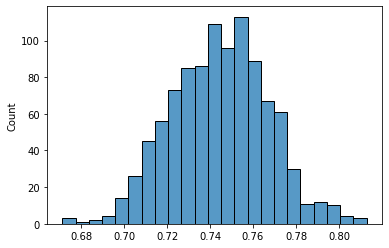

In [6]:
val_f1 = []
for i in range(1000):  
  y_train = train_data.iloc[:,-1:]
  X_train = train_data.iloc[:,:-1]
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .15, stratify = y_train, random_state = i)
  #X_train = scalar.fit_transform(X_train)
  #X_test = scalar.fit_transform(test_data)
  knn = KNeighborsClassifier(n_neighbors=544, weights ='distance', p=1)
  knn.fit((X_train), np.ravel(y_train))
  y_pred = knn.predict(X_val)
  val_f1.append(f1_score(y_val, y_pred))

sns.histplot(val_f1)


For fun, I chose a random state which generated the best result and printed the accuracy metrics.

generate roc_auc, f1 score, and accuracy score for the model I ended up with

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .15, stratify = y_train, random_state = 629)
knn = KNeighborsClassifier(n_neighbors=544, weights ='distance', p=1)
knn.fit((X_train), np.ravel(y_train))
y_pred = knn.predict(X_val)
y_pred_true = knn.predict_proba(X_val)[:,1]

print(roc_auc_score(y_val, y_pred_true))
print(f1_score(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

0.8065764023210833
0.7669172932330828
0.696078431372549


## Train model on best state in the distribution generated previously.

## Test the model on the test data.

In [ ]:

y_train = train_data.iloc[:,-1:]
X_train = train_data.iloc[:,:-1]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .15, stratify = y_train, random_state = 629)
knn = KNeighborsClassifier(n_neighbors=544, weights ='distance', p=1)
knn.fit((X_train), np.ravel(y_train))
y_pred = knn.predict(test_data)

In [ ]:
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
submission = pd.DataFrame(data={'quality': y_pred}, index = test_data.index)
submission.to_csv('knnSubmission.csv', index = True, index_label='id')